# Cell states of the tumor immune microenvironment (TIME)
author: Margaret Paiva

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# # table with clinical responses
# # complete response (CR) and partial response (PR) for responders, 
# # stable disease (SD) and progressive disease (PD) for nonresponders
# meta = pd.read_csv('data/GSE120575_patient_ID_single_cells.txt.gz', 
#                    sep="\t", encoding="latin", 
#                    skiprows=19).iloc[:, :7]
# # remove additional information after sample table
# meta = meta.iloc[:16291]

# # rename columns by removing the `characteristics: ` prefix to make it more concise
# meta.columns = [x.replace("characteristics: ", "") for x in meta.columns]

# # rename the long `patient ID (...)` column to simple sample_id
# meta.rename(
#     columns={"patinet ID (Pre=baseline; Post= on treatment)": "sample_id"},
#     inplace=True
# )

# # add columns that seperate sample_id for later analysis
# meta["patient_id"] = [x.split("_")[1] for x in meta.sample_id]
# meta["time_point"] = [x.split("_")[0] for x in meta.sample_id]

# meta.head(3)

In [3]:
ge = sc.read_h5ad('data/GSE120575_annotated.h5ad')
ge

AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
# n = 1
# for g in ["sample_id",
#      "time_point", 
#      "response",
#      "cell_type"]:
#     n *= data[g].nunique()
# print(n)'

In [5]:
# "23" -> 2 + 3 + 23
# # f("342") -> 3 + 4 + 2 + 34 + 42 + 342
# # WRONG:
# # def f(s):
# #    return sum([(int(c) for c in s)] + int(s))
# def f(s):
#     n = 0
#     for i in range(len(s)):
#         for j in range(len(s)-i):
#             n += int(s[j:j+i+1])
#     return n

In [6]:
data = ge.obs.copy()

# group cells by cluster and sample_id
cluster_pct = data.groupby(
    [ "response",
     "time_point", 
     "sample_id",
     "cell_type"],
    observed=True
).size().reset_index().rename(
    columns={0: "cells"}
)

# calculate percentage of each cluster in each sample
cluster_pct = cluster_pct.merge(
    data.groupby("sample_id").size().reset_index()
).rename(columns={0: "total_cells"})

cluster_pct["percent"] = cluster_pct.cells / cluster_pct.total_cells
cluster_pct.head(3)

,response,time_point,sample_id,cell_type,cells,total_cells,percent
0,Responder,Pre,Pre_P1,Dendritic cells,17,229,0.074236
1,Responder,Pre,Pre_P1,B cells,4,229,0.017467
2,Responder,Pre,Pre_P1,Memory T cells,9,229,0.039301


In [7]:
cluster_pct.tail(3)

,response,time_point,sample_id,cell_type,cells,total_cells,percent
424,Non-responder,Post,Post_P30,CD4+ T cells,21,369,0.056911
425,Non-responder,Post,Post_P30,Macrophages,41,369,0.111111
426,Non-responder,Post,Post_P30,Exhausted T cells,8,369,0.021680


In [8]:
pct_mat = cluster_pct.pivot_table(
    index= ["response", "time_point", "sample_id"],
    columns=["cell_type"], values="percent",
#     fill_value=0
)

In [9]:
pct_mat

cell_type                             B cells  CD4+ T cells  CD8+ T cells  \
response      time_point sample_id                                          
Non-responder Post       Post_P1_2   0.084986      0.096317      0.645892   
                         Post_P2     0.034301      0.073879      0.556728   
                         Post_P3     0.013966      0.139665      0.427374   
                         Post_P3_2   0.005587      0.081006      0.608939   
                         Post_P5     0.010274      0.075342      0.551370   
                         Post_P6     0.037688      0.022613      0.203518   
                         Post_P10    0.035806      0.053708      0.324808   
                         Post_P11    0.009615      0.076923      0.567308   
                         Post_P12    0.006211      0.034161      0.739130   
                         Post_P13    0.266816      0.033632      0.163677   
                         Post_P14    0.069909      0.066869      0.303951   
                         Post_P15    0.016611      0.099668      0.328904   
                         Post_P16    0.034632      0.062771      0.419913   
                         Post_P18    0.478992      0.084034      0.168067   
                         Post_P20    0.050279      0.055866      0.315642   
                         Post_P22    0.011583      0.189189      0.386100   
                         Post_P23    0.016807      0.103641      0.549020   
                         Post_P23_2  0.046961      0.088398      0.635359   
                         Post_P28    0.003077      0.021538      0.024615   
                         Post_P28_2  0.002688      0.064516      0.368280   
                         Post_P30    0.010840      0.056911      0.514905   
              Pre        Pre_P2      0.014837      0.029674      0.688427   
                         Pre_P3      0.061224      0.081633      0.355102   
                         Pre_P4      0.051613      0.064516      0.403226   
                         Pre_P6      0.178947      0.014035      0.122807   
                         Pre_P12     0.015198      0.060790      0.580547   
                         Pre_P15     0.009868      0.128289      0.299342   
                         Pre_P20     0.031153      0.056075      0.576324   
                         Pre_P25     0.008086      0.194070      0.458221   
                         Pre_P27     0.002915      0.052478      0.658892   
                         Pre_P31     0.008571      0.045714      0.708571   
Responder     Post       Post_P1     0.034602      0.041522           NaN   
                         Post_P4     0.379259      0.057778      0.208889   
                         Post_P5_2   0.002976      0.080357      0.741071   
                         Post_P7     0.017316      0.047619      0.610390   
                         Post_P8     0.317848      0.036675      0.317848   
                         Post_P17    0.167260      0.028470      0.651246   
                         Post_P19    0.276119      0.069652      0.238806   
                         Post_P21    0.230047      0.107981      0.262911   
              Pre        Pre_P1      0.017467      0.043668      0.589520   
                         Pre_P7      0.141304      0.127717      0.385870   
                         Pre_P8      0.093985      0.101504      0.342105   
                         Pre_P24     0.056213      0.088757      0.473373   
                         Pre_P26          NaN      0.033033      0.138138   
                         Pre_P28     0.023739      0.124629      0.388724   
                         Pre_P29     0.067485      0.067485      0.472393   
                         Pre_P33     0.141593      0.139381      0.455752   
                         Pre_P35     0.378151      0.084034      0.201681   

cell_type                            Dendritic cells  Exhausted T cells  \
response      time_point sample_id                                        

In [10]:
# Calculate P values using Mann-Whitney U test
def pct_test(data, cluster):
    _data = data[cluster].reset_index()
    resp_pct = _data.loc[_data.response == "Responder", cluster].values
    nonresp_pct = _data.loc[_data.response == "Non-responder", cluster].values
    stat, pval = mannwhitneyu(resp_pct, nonresp_pct, 
                              alternative='two-sided', 
                              method='exact', 
                              nan_policy='omit')
    return {"cluster": cluster,
            "median_responder_pct": np.nanmedian(resp_pct),
            "median_nonresponder_pct": np.nanmedian(nonresp_pct),
            "pvalue": pval}

In [11]:
res = pd.DataFrame(
    [pct_test(pct_mat, cluster) for cluster in pct_mat.columns]
)
res.sort_values("pvalue")

,cluster,median_responder_pct,median_nonresponder_pct,pvalue
0,B cells,0.117645,0.016611,0.001787
5,Macrophages,0.017936,0.047486,0.037014
4,Exhausted T cells,0.046196,0.030888,0.369017
2,CD8+ T cells,0.387297,0.427374,0.555811
3,Dendritic cells,0.023474,0.035874,0.700907
8,others,0.095355,0.081794,0.700907
1,CD4+ T cells,0.069652,0.064516,0.748946
7,Regulatory T cells,0.082969,0.089636,0.847763
6,Memory T cells,0.062189,0.065421,0.898170


In [14]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

<AxesSubplot:xlabel='time_point', ylabel='percent'>

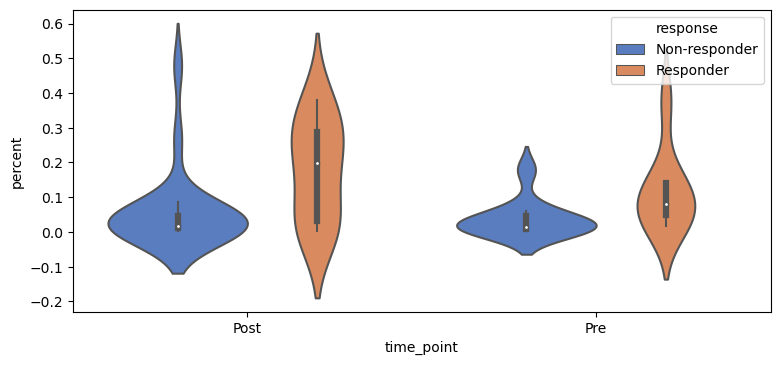

In [15]:
plt.figure(figsize=(9, 4), dpi=100)
sns.violinplot(x="time_point", y="percent", hue="response",
               data=cluster_pct.loc[cluster_pct.cell_type=='B cells'], 
               palette="muted")

<AxesSubplot:xlabel='time_point', ylabel='percent'>

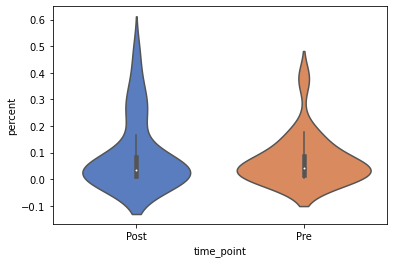

In [16]:
sns.violinplot(x="time_point", y="percent",
               data=cluster_pct.loc[cluster_pct.cell_type=='B cells'], 
               palette="muted")

<AxesSubplot:xlabel='time_point', ylabel='percent'>

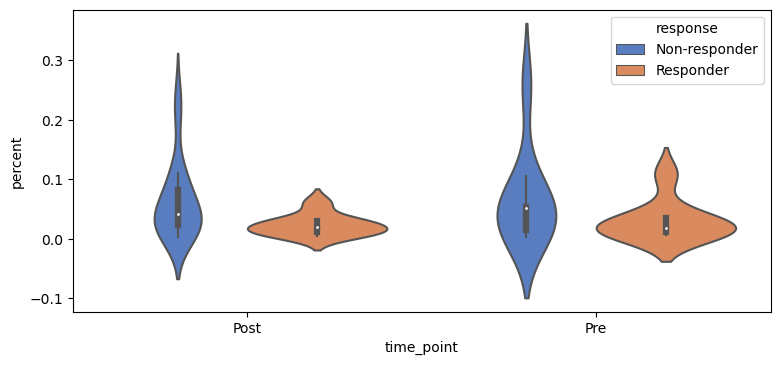

In [17]:
plt.figure(figsize=(9, 4), dpi=100)
sns.violinplot(x="time_point", y="percent", hue="response",
               data=cluster_pct.loc[cluster_pct.cell_type=='Macrophages'], 
               palette="muted")

<AxesSubplot:xlabel='time_point', ylabel='percent'>

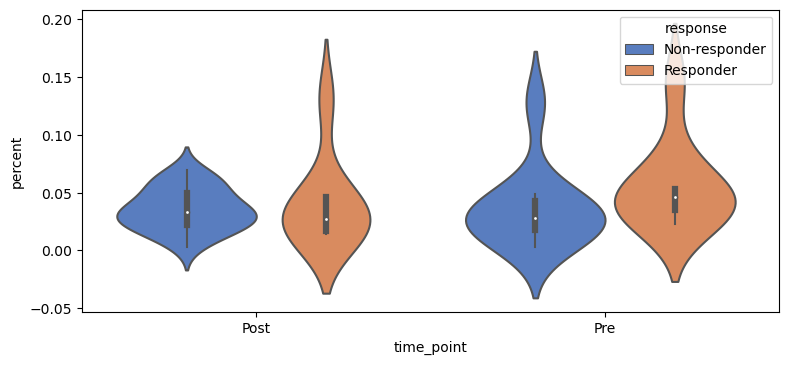

In [18]:
plt.figure(figsize=(9, 4), dpi=100)
sns.violinplot(x="time_point", y="percent", hue="response",
               data=cluster_pct.loc[cluster_pct.cell_type=='Exhausted T cells'], 
               palette="muted")

<AxesSubplot:xlabel='time_point', ylabel='percent'>

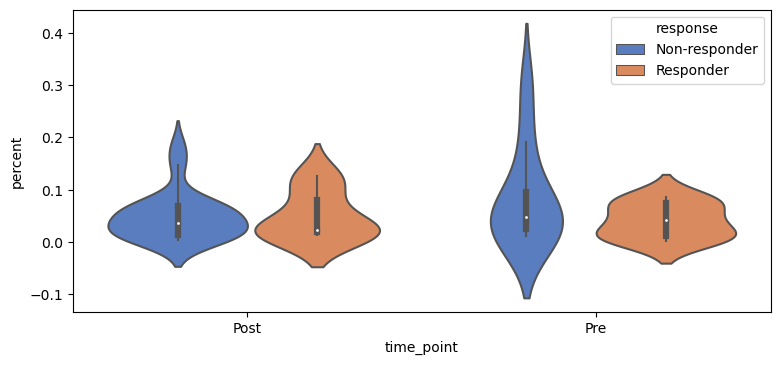

In [19]:
plt.figure(figsize=(9, 4), dpi=100)
sns.violinplot(x="time_point", y="percent", hue="response",
               data=cluster_pct.loc[cluster_pct.cell_type=='Dendritic cells'], 
               palette="muted")